<a href="https://colab.research.google.com/github/djsg2021utec/TESIS_MAESTRIA/blob/main/Filtros_de_video.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
%pip install ffmpeg
from tqdm import tqdm
import time
import os
from base64 import b64encode
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from IPython.display import HTML
from base64 import b64encode
import glob
from random import shuffle
import tensorflow as tf
import torch
import shutil
import sys
from torch.utils.data import DataLoader, TensorDataset, random_split
import ffmpeg

## Tratamiento de videos:

Objetivo quedarte con solo los frames que muestren personas y distorsione las zonas fuera.

1.

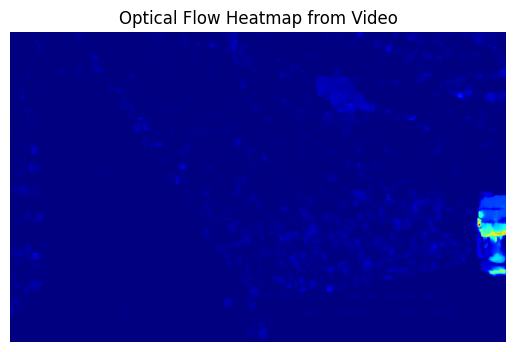

'/mnt/data/optical_flow_heatmap_video.png'

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Cargamos el video proporcionado por el usuario
video_path = '/content/descarga (3).mp4'
cap = cv2.VideoCapture(video_path)

# Leemos los dos primeros frames del video
ret, frame1 = cap.read()
ret, frame2 = cap.read()

# Convertimos los frames a escala de grises
prvs = cv2.cvtColor(frame1, cv2.COLOR_BGR2GRAY)
next = cv2.cvtColor(frame2, cv2.COLOR_BGR2GRAY)

# Calculamos el flujo óptico utilizando el algoritmo Farneback
flow = cv2.calcOpticalFlowFarneback(prvs, next, None, 0.5, 3, 15, 3, 5, 1.2, 0)

# Obtenemos la magnitud y el ángulo del flujo
magnitude, angle = cv2.cartToPolar(flow[..., 0], flow[..., 1])

# Normalizamos la magnitud para que esté entre 0 y 255
magnitude = cv2.normalize(magnitude, None, 0, 255, cv2.NORM_MINMAX)

# Aplicamos un mapa de calor a la magnitud normalizada del flujo óptico
heat_map = cv2.applyColorMap(np.uint8(magnitude), cv2.COLORMAP_JET)

# Guardamos la imagen resultante del mapa de calor
output_path_heatmap = '/mnt/data/optical_flow_heatmap_video.png'
cv2.imwrite(output_path_heatmap, heat_map)

# Mostramos la imagen resultante
plt.imshow(cv2.cvtColor(heat_map, cv2.COLOR_BGR2RGB))
plt.title('Optical Flow Heatmap from Video')
plt.axis('off')
plt.show()

# Liberamos el capturador de video
cap.release()

output_path_heatmap


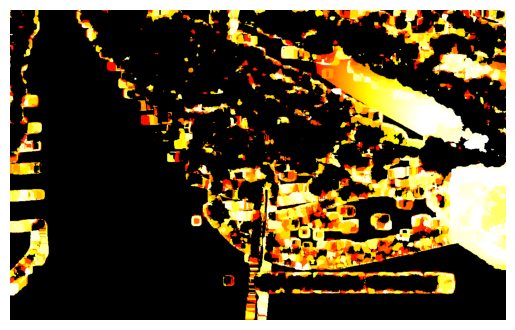

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Función para procesar un video y resaltar los bordes y el movimiento
def process_video(video_path, output_path):
    cap = cv2.VideoCapture(video_path)
    ret, prev_frame = cap.read()

    # Convertimos el primer frame a escala de grises y encontramos los bordes
    prev_gray = cv2.cvtColor(prev_frame, cv2.COLOR_BGR2GRAY)
    prev_edges = cv2.Canny(prev_gray, threshold1=50, threshold2=100)

    # Inicializamos la imagen de flujo óptico acumulado
    h, w = prev_gray.shape[:2]
    motion_history = np.zeros((h, w), dtype=np.float32)

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        # Convertimos el frame a escala de grises y detectamos bordes
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        edges = cv2.Canny(gray, threshold1=50, threshold2=100)

        # Calculamos el flujo óptico entre los bordes del frame actual y el anterior
        flow = cv2.calcOpticalFlowFarneback(prev_edges, edges, None, 0.5, 3, 15, 3, 5, 1.2, 0)
        magnitude, _ = cv2.cartToPolar(flow[..., 0], flow[..., 1])

        # Actualizamos el historial de movimiento sólo en áreas con movimiento significativo
        motion_history = np.maximum(motion_history - 1, 0)  # Decaimiento
        motion_history[magnitude > 1.0] = 255  # Resaltar movimiento

        # Preparamos el siguiente ciclo
        prev_edges = edges

    cap.release()

    # Normalizamos el historial de movimiento
    motion_history_norm = cv2.normalize(motion_history, None, 0, 255, cv2.NORM_MINMAX)

    # Aplicamos un mapa de calor al historial de movimiento normalizado
    motion_heatmap = cv2.applyColorMap(motion_history_norm.astype(np.uint8), cv2.COLORMAP_HOT)

    # Guardamos el mapa de calor
    cv2.imwrite(output_path, motion_heatmap)

# Ruta al archivo de video y a la salida del mapa de calor
video_path = '/content/descarga (3).mp4'
output_path = 'tu_salida.png'

# Procesamos el video
process_video(video_path, output_path)

# Mostramos el resultado
motion_heatmap = cv2.imread(output_path)
plt.imshow(cv2.cvtColor(motion_heatmap, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()


In [2]:
%%capture
%pip install ultralytics

import cv2
from ultralytics import YOLO

# Load the YOLOv8 model
model = YOLO('yolov8n.pt')

# Open the video file
video_path = "/content/descarga (3).mp4"
cap = cv2.VideoCapture(video_path)

# Define the codec and create VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'mp4v') # or 'XVID' if .avi
fps = cap.get(cv2.CAP_PROP_FPS)
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
out = cv2.VideoWriter('/content/output_video.mp4', fourcc, fps, (frame_width, frame_height))

# Loop through the video frames
while cap.isOpened():
    # Read a frame from the video
    success, frame = cap.read()

    if success:
        # Run YOLOv8 tracking on the frame, persisting tracks between frames
        results = model.track(frame, classes=0, persist=True)

        # Visualize the results on the frame
        annotated_frame = results[0].plot()

        # Write the frame into the file 'output_video.mp4'
        out.write(annotated_frame)

        # Uncomment this line if you want to see the frame in Colab
        # cv2_imshow(annotated_frame)

        # Break the loop if 'q' is pressed (this won't work in Colab)
        if cv2.waitKey(1) & 0xFF == ord("q"):
            break
    else:
        # Break the loop if the end of the video is reached
        break

# Release everything when the job is finished
cap.release()
out.release()
cv2.destroyAllWindows()



In [21]:
results = model.track(frame, classes=0, persist=True)
results[0].boxes

tensor([], device='cuda:0', size=(0, 4))

In [8]:
import os
import subprocess
import ffmpeg
video_name = video_path.split("/")[-1:][0].split(".")[0]
output_video_path = '/content/output_video.mp4'
compressed_video_path = '/content/output_video_compressed.mp4'
command = [
    'ffmpeg',
    '-i', output_video_path,
    '-vcodec', 'h264',
    '-acodec', 'mp2',
    compressed_video_path
]
subprocess.run(command)

CompletedProcess(args=['ffmpeg', '-i', '/content/output_video.mp4', '-vcodec', 'h264', '-acodec', 'mp2', '/content/output_video_compressed.mp4'], returncode=0)

In [9]:

import os
import subprocess
import ffmpeg
video_width = 500
path='/content/output_video_compressed.mp4'
video_file = open(path,"rb").read()
video_url = f"data:video/mp4;base64,{b64encode(video_file).decode()}"
HTML(f"""<video width={video_width} controls><source src="{video_url}"></video>""")

In [51]:
import cv2
import numpy as np

# Inicializar el capturador de video

model = YOLO('yolov8n.pt')

cap = cv2.VideoCapture('/content/descarga (3).mp4')

# Definir el codec y crear un objeto VideoWriter para la salida del video
fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter('/content/output_persons_heatmaps.mp4', fourcc, 20.0, (int(cap.get(3)), int(cap.get(4))))

# Leer el primer frame para inicializar el proceso
ret, prev_frame = cap.read()
prev_gray = cv2.cvtColor(prev_frame, cv2.COLOR_BGR2GRAY)

frame_idx = 0  # Índice del frame actual


while cap.isOpened():
    ret, curr_frame = cap.read()
    if not ret:
        break

    # Realizar el seguimiento en el frame actual
    results = model.track(curr_frame, classes=0, persist=True)
    curr_gray = cv2.cvtColor(curr_frame, cv2.COLOR_BGR2GRAY)

    # Verificar si se obtuvieron resultados
    if results and hasattr(results[0], 'boxes'):
        bounding_boxes = results[0].boxes.xywh

        # Mover los datos del tensor al host (CPU) y convertir a NumPy
        if isinstance(bounding_boxes, torch.Tensor):
            bounding_boxes = bounding_boxes.cpu().numpy()

        # Desempaquetar las coordenadas del bounding box
        for bbox in bounding_boxes:
            x_center, y_center, width, height = bbox[:4]

            # Convertir a coordenadas de la esquina superior izquierda
            x = int(x_center - width / 2)
            y = int(y_center - height / 2)
            w = int(width)
            h = int(height)

            # Asegurarte de que el ROI no exceda los límites de la imagen
            x, y = max(0, x), max(0, y)
            w, h = min(curr_gray.shape[1] - x, w), min(curr_gray.shape[0] - y, h)

            # Extraer la región de interés basada en el bounding box actual
            prev_roi = prev_gray[y:y+h, x:x+w]
            curr_roi = curr_gray[y:y+h, x:x+w]

            # Calcular el flujo óptico utilizando el algoritmo de Farneback
            flow = cv2.calcOpticalFlowFarneback(prev_roi, curr_roi, None, 0.5, 3, 15, 3, 5, 1.2, 0)

            # Calcular la magnitud y el ángulo del flujo óptico
            magnitude, angle = cv2.cartToPolar(flow[..., 0], flow[..., 1])

            # Normalizar y escalar la magnitud para el mapa de calor
            magnitude = cv2.normalize(magnitude, None, 0, 1, cv2.NORM_MINMAX)

            # Generar el mapa de calor y convertir a formato BGR para superponer
            heatmap = cv2.applyColorMap((magnitude*255).astype(np.uint8), cv2.COLORMAP_JET)

            # Superponer el mapa de calor en el frame actual dentro del bounding box
            curr_frame[y:y+h, x:x+w] = cv2.addWeighted(curr_frame[y:y+h, x:x+w], 0.5, heatmap, 0.5, 0)

        # Guardar el frame con el mapa de calor superpuesto
        out.write(curr_frame)

        # Actualizar el frame anterior
        prev_gray = curr_gray

    else:
        # Si no hay resultados, simplemente escribir el frame original
        out.write(curr_frame)

# Liberar el capturador de video y el escritor, y cerrar todas las ventanas
cap.release()
out.release()
cv2.destroyAllWindows()


In [52]:
import os
import subprocess
import ffmpeg
video_name = video_path.split("/")[-1:][0].split(".")[0]
output_video_path = '/content/output_persons_heatmaps.mp4'
compressed_video_path = '/content/output_persons_heatmaps_compressed.mp4'
command = [
    'ffmpeg',
    '-i', output_video_path,
    '-vcodec', 'h264',
    '-acodec', 'mp2',
    compressed_video_path
]
subprocess.run(command)

CompletedProcess(args=['ffmpeg', '-i', '/content/output_persons_heatmaps.mp4', '-vcodec', 'h264', '-acodec', 'mp2', '/content/output_persons_heatmaps_compressed.mp4'], returncode=0)

In [53]:
import os
import subprocess
import ffmpeg
video_width = 500
path='/content/output_persons_heatmaps_compressed.mp4'
video_file = open(path,"rb").read()
video_url = f"data:video/mp4;base64,{b64encode(video_file).decode()}"
HTML(f"""<video width={video_width} controls><source src="{video_url}"></video>""")

In [57]:
import cv2
import numpy as np
import torch

# Inicializar el capturador de video
model = YOLO('yolov8n.pt')
cap = cv2.VideoCapture('/content/descarga (3).mp4')

# Definir el codec y crear un objeto VideoWriter para la salida del video
fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter('/content/output_persons_heatmaps_white.mp4', fourcc, 20.0, (int(cap.get(3)), int(cap.get(4))))

while cap.isOpened():
    ret, curr_frame = cap.read()
    if not ret:
        break

    # Realizar el seguimiento en el frame actual
    results = model.track(curr_frame, classes=0, persist=True)
    curr_gray = cv2.cvtColor(curr_frame, cv2.COLOR_BGR2GRAY)

    # Crear una máscara con el mismo tamaño del frame, inicialmente en blanco (todos los píxeles en 255)
    mask = np.ones_like(curr_frame) * 255

    # Verificar si se obtuvieron resultados
    if results and hasattr(results[0], 'boxes'):
        bounding_boxes = results[0].boxes.xywh

        # Mover los datos del tensor al host (CPU) y convertir a NumPy
        if isinstance(bounding_boxes, torch.Tensor):
            bounding_boxes = bounding_boxes.cpu().numpy()

        # Desempaquetar las coordenadas del bounding box
        for bbox in bounding_boxes:
            x_center, y_center, width, height = bbox[:4]

            # Convertir a coordenadas de la esquina superior izquierda
            x = int(x_center - width / 2)
            y = int(y_center - height / 2)
            w = int(width)
            h = int(height)

            # Asegurarte de que el ROI no exceda los límites de la imagen
            x, y = max(0, x), max(0, y)
            w, h = min(curr_gray.shape[1] - x, w), min(curr_gray.shape[0] - y, h)

            # Poner ceros en la máscara donde están los bounding boxes (regiones de interés)
            mask[y:y+h, x:x+w] = 0

            # Extraer la región de interés basada en el bounding box actual
            prev_roi = prev_gray[y:y+h, x:x+w]
            curr_roi = curr_gray[y:y+h, x:x+w]

            # Calcular el flujo óptico utilizando el algoritmo de Farneback
            flow = cv2.calcOpticalFlowFarneback(prev_roi, curr_roi, None, 0.5, 3, 15, 3, 5, 1.2, 0)

            # Calcular la magnitud y el ángulo del flujo óptico
            magnitude, angle = cv2.cartToPolar(flow[..., 0], flow[..., 1])

            # Normalizar y escalar la magnitud para el mapa de calor
            magnitude = cv2.normalize(magnitude, None, 0, 1, cv2.NORM_MINMAX)

            # Generar el mapa de calor y convertir a formato BGR para superponer
            heatmap = cv2.applyColorMap((magnitude*255).astype(np.uint8), cv2.COLORMAP_JET)

            # Superponer el mapa de calor en el frame actual dentro del bounding box
            curr_frame[y:y+h, x:x+w] = cv2.addWeighted(curr_frame[y:y+h, x:x+w], 0.5, heatmap, 0.5, 0)

        # Combinar el frame con la máscara: Esto blanqueará las áreas fuera de los bounding boxes
        combined_frame = cv2.bitwise_or(curr_frame, mask)

        # Guardar el frame con las regiones fuera del bounding box blanqueadas
        out.write(combined_frame)

        # Actualizar el frame anterior
        prev_gray = curr_gray

    else:
        # Si no hay resultados, simplemente escribir el frame original
        out.write(curr_frame)

# Liberar el capturador de video y el escritor, y cerrar todas las ventanas
cap.release()
out.release()
cv2.destroyAllWindows()


In [58]:
import os
import subprocess
import ffmpeg
video_name = video_path.split("/")[-1:][0].split(".")[0]
output_video_path = '/content/output_persons_heatmaps_white.mp4'
compressed_video_path = '/content/output_persons_heatmaps_white_compressed.mp4'
command = [
    'ffmpeg',
    '-i', output_video_path,
    '-vcodec', 'h264',
    '-acodec', 'mp2',
    compressed_video_path
]
subprocess.run(command)

CompletedProcess(args=['ffmpeg', '-i', '/content/output_persons_heatmaps_white.mp4', '-vcodec', 'h264', '-acodec', 'mp2', '/content/output_persons_heatmaps_white_compressed.mp4'], returncode=0)

In [59]:
import os
import subprocess
import ffmpeg
video_width = 500
path='/content/output_persons_heatmaps_white_compressed.mp4'
video_file = open(path,"rb").read()
video_url = f"data:video/mp4;base64,{b64encode(video_file).decode()}"
HTML(f"""<video width={video_width} controls><source src="{video_url}"></video>""")

In [ ]:
import cv2

# Define la ruta del video
video_path = 'tu_video.mp4'

# Carga el video
video = cv2.VideoCapture(video_path)

# Verifica si el video se abrió correctamente
if not video.isOpened():
    print("Error al abrir el video")
else:
    # Lee un fotograma del video
    success, frame = video.read()
    if success:
        # Guarda el fotograma como imagen
        cv2.imwrite('frame_extraido.jpg', frame)
    else:
        print("Error al leer el video")

# Cierra el video
video.release()

In [50]:
# Ruta al archivo de video y a la salida del mapa de calor
video_path = '/content/output_persons_heatmaps.mp4'
output_path = 'flatten_person_heatmap.png'

# Procesamos el video
process_video(video_path, output_path)

# Mostramos el resultado
motion_heatmap = cv2.imread(output_path)
plt.imshow(cv2.cvtColor(motion_heatmap, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()


array([     1066.9,      472.42,      63.774,      120.28], dtype=float32)

In [49]:
results[0].boxes.

ultralytics.engine.results.Boxes object with attributes:

cls: tensor([], device='cuda:0')
conf: tensor([], device='cuda:0')
data: tensor([], device='cuda:0', size=(0, 6))
id: None
is_track: False
orig_shape: (720, 1152)
shape: torch.Size([0, 6])
xywh: tensor([], device='cuda:0', size=(0, 4))
xywhn: tensor([], device='cuda:0', size=(0, 4))
xyxy: tensor([], device='cuda:0', size=(0, 4))
xyxyn: tensor([], device='cuda:0', size=(0, 4))

In [44]:
bounding_boxes

array([], shape=(0, 4), dtype=float32)

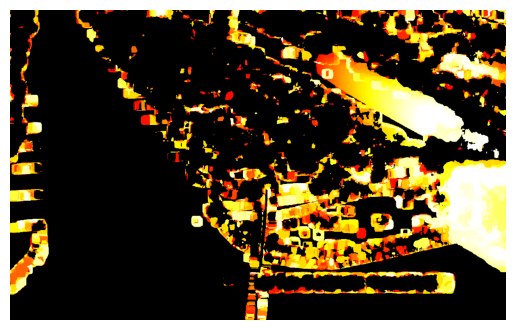

In [10]:
# Ruta al archivo de video y a la salida del mapa de calor
video_path = '/content/output_video_compressed.mp4'
output_path = 'tu_salida.png'

# Procesamos el video
process_video(video_path, output_path)

# Mostramos el resultado
motion_heatmap = cv2.imread(output_path)
plt.imshow(cv2.cvtColor(motion_heatmap, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()


In [3]:
%pip install timm
from urllib.request import urlopen
from PIL import Image
import timm

img = Image.open(urlopen(
    'https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/beignets-task-guide.png'
))

model = timm.create_model(
    'fastvit_t8.apple_in1k',
    pretrained=True,
    num_classes=0,  # remove classifier nn.Linear
)
model = model.eval()

# get model specific transforms (normalization, resize)
data_config = timm.data.resolve_model_data_config(model)
transforms = timm.data.create_transform(**data_config, is_training=False)

output = model(transforms(img).unsqueeze(0))  # output is (batch_size, num_features) shaped tensor

# or equivalently (without needing to set num_classes=0)

output = model.forward_features(transforms(img).unsqueeze(0))
# output is unpooled, a (1, 384, 8, 8) shaped tensor

output = model.forward_head(output, pre_logits=True)
# output is a (1, num_features) shaped tensor


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 20.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 33.5 MB/s eta 0:00:00


model.safetensors:   0%|          | 0.00/16.3M [00:00<?, ?B/s]

In [4]:
output

tensor([[ 2.1408e-01,  1.4003e-01, -1.5318e-02,  3.7157e-01,  4.2211e-01,  7.2011e-01, -6.6934e-03,  1.6529e-01, -1.1628e-01, -8.0616e-02,  1.3186e+00,  7.4621e-02,  7.2043e-01,  6.2680e-03, -5.9733e-02,  1.0448e-01,  7.1104e-02, -1.5620e-02,  3.2502e-01,  2.8424e-01,  3.1304e-01,  1.0967e+00, -6.4194e-02,  1.1233e-02,
          8.2102e-01,  1.4378e-02,  2.9916e-01,  8.0107e-01, -2.0703e-02,  2.5118e-04,  1.0878e+00,  2.0261e-02,  2.2589e-01,  2.4060e+00,  1.3901e-01,  9.5222e-01,  1.2031e+00,  7.8049e-01,  2.3254e-01,  5.4434e-01,  6.5171e-01,  2.7895e-01,  9.6860e-01,  3.8819e-01,  2.5137e-01,  3.7059e-01, -7.0560e-02,  2.7139e-01,
          1.2011e+00, -5.2399e-02,  5.4950e-01,  8.3354e-02,  3.4461e-01,  5.3025e-02,  3.4704e-01,  2.9558e+00,  4.1763e-01,  1.1520e-01, -3.8647e-02, -8.9643e-05, -5.5717e-02, -5.3952e-02,  3.7982e-01,  7.4443e-01,  3.5980e-01,  8.4721e-02,  9.7216e-01,  1.4109e-01,  4.9133e-01,  1.6050e-01,  7.9315e-02,  6.3210e-01,
          1.3291e-01,  9.0183e-01,  1

In [ ]:
results

[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 masks: None
 names: {0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic light', 10: 'fire hydrant', 11: 'stop sign', 12: 'parking meter', 13: 'bench', 14: 'bird', 15: 'cat', 16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow', 20: 'elephant', 21: 'bear', 22: 'zebra', 23: 'giraffe', 24: 'backpack', 25: 'umbrella', 26: 'handbag', 27: 'tie', 28: 'suitcase', 29: 'frisbee', 30: 'skis', 31: 'snowboard', 32: 'sports ball', 33: 'kite', 34: 'baseball bat', 35: 'baseball glove', 36: 'skateboard', 37: 'surfboard', 38: 'tennis racket', 39: 'bottle', 40: 'wine glass', 41: 'cup', 42: 'fork', 43: 'knife', 44: 'spoon', 45: 'bowl', 46: 'banana', 47: 'apple', 48: 'sandwich', 49: 'orange', 50: 'broccoli', 51: 'carrot', 52: 'hot dog', 53: 'pizza', 54: 'donut', 55: 'cake', 56: 'chair', 57: 'couch', 58: 'potted p